# **`Position Recommendations for Footballers Using Python and Scikit-learn `**

**Objective**: This project aims to help football players and coaches select the most suitable playing position for a player based on their physical attributes and skills. Using machine learning techniques, the model selects and ranks the best positions for a player, assisting in optimal team selection and player development.

**Dataset**: https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset

**Credit**: Stefano Leone

## `STEP 0: Load the Dataset and Import important tools`

In [ ]:
!pip install streamlit

In [28]:
# Import important tools

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import streamlit as st
from pyngrok import ngrok

# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading the Dataset from Google Drive (Saved from Kaggle)

df = pd.read_csv('/content/drive/MyDrive/male_players.csv')

## `STEP 1: Data Cleaning and Feature Extraction`

**`1.1 Data Cleaning`**

In [30]:
# View all columns name

print(list(df.columns))

['player_id', 'player_url', 'fifa_version', 'fifa_update', 'update_as_of', 'short_name', 'long_name', 'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_team_id', 'club_name', 'league_id', 'league_name', 'league_level', 'club_position', 'club_jersey_number', 'club_loaned_from', 'club_joined_date', 'club_contract_valid_until_year', 'nationality_id', 'nationality_name', 'nation_team_id', 'nation_position', 'nation_jersey_number', 'preferred_foot', 'weak_foot', 'skill_moves', 'international_reputation', 'work_rate', 'body_type', 'real_face', 'release_clause_eur', 'player_tags', 'player_traits', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed'

In [31]:
pos_list = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
            'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
            'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

columns = ['short_name', 'player_positions', 'height_cm', 'weight_kg',
        'preferred_foot', 'weak_foot', 'skill_moves',
        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
        'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
        'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
        'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
        'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']

In [32]:
# Data Cleaning

# Filter out goalkeepers and FIFA version is 22, 23 or 24
filtered_df = df.loc[(df['player_positions'] != 'GK') & (df['fifa_version'].isin([22.0, 23.0, 24.0])), columns].copy()

# Split positions into lists
filtered_df['player_positions'] = filtered_df['player_positions'].apply(lambda x: x.split(', '))

# Calculate BMI from height and weight
filtered_df['height_m'] = filtered_df['height_cm'] / 100  # Convert height from cm to m
filtered_df['bmi'] = filtered_df['weight_kg'] / (filtered_df['height_m'] ** 2)  # BMI calculation

# Convert preferred_foot to numerical (Right as 0 and Left as 1)
filtered_df['preferred_foot'] = filtered_df['preferred_foot'].map({'Right': 0, 'Left': 1})

# Create a list of 0, 1 for each position in pos_list (1 if position is in player_positions)
def create_position_encoding(player_positions, pos_list):
    encoding = [1 if pos in player_positions else 0 for pos in pos_list]
    return encoding

# Create position encodings
filtered_df['position_encoded'] = filtered_df['player_positions'].apply(lambda x: create_position_encoding(x, pos_list))

# Normalize Skills by Dividing by Max Skill (to emphasize "relative" strengths)
skill_columns = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
        'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
        'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
        'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
        'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']

filtered_df['max_skill'] = filtered_df[skill_columns].max(axis=1)
for column in skill_columns:
    filtered_df[column] = filtered_df[column]/filtered_df['max_skill']

filtered_df

,short_name,player_positions,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,...,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,height_m,bmi,position_encoded,max_skill
0,K. Mbappé,"[ST, LW]",182,75,0,4,5,0.804124,0.969072,0.752577,...,0.855670,0.865979,0.907216,0.268041,0.350515,0.329897,1.82,22.642193,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",97.0
1,E. Haaland,[ST],195,94,1,3,3,0.489583,1.000000,0.864583,...,0.770833,0.875000,0.906250,0.395833,0.489583,0.302083,1.95,24.720579,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",96.0
2,K. De Bruyne,"[CM, CAM]",181,75,0,5,4,1.000000,0.894737,0.578947,...,1.000000,0.873684,0.926316,0.694737,0.736842,0.557895,1.81,22.893074,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",95.0
3,L. Messi,"[CF, CAM]",169,67,1,4,4,0.864583,0.927083,0.625000,...,0.958333,0.781250,1.000000,0.208333,0.364583,0.250000,1.69,23.458562,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",96.0
4,K. Benzema,"[CF, ST]",185,81,0,4,4,0.815217,0.989130,0.978261,...,0.978261,0.923913,0.978261,0.467391,0.260870,0.195652,1.85,23.666910,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56115,Fang Xinfeng,[CDM],189,79,0,2,2,0.580645,0.419355,0.661290,...,0.580645,0.709677,0.612903,0.629032,0.758065,0.741935,1.89,22.115842,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",62.0
56116,D. Collins,"[ST, RM]",174,68,0,3,2,0.579710,0.710145,0.434783,...,0.753623,0.579710,0.681159,0.565217,0.420290,0.391304,1.74,22.460034,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",69.0
56117,Hu Xingyu,[CM],178,68,0,2,2,0.478261,0.376812,0.681159,...,0.666667,0.623188,0.521739,0.536232,0.536232,0.666667,1.78,21.461937,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",69.0
56120,N. Logue,[CM],178,72,0,3,2,0.650000,0.533333,0.716667,...,0.766667,0.650000,0.600000,0.633333,0.733333,0.800000,1.78,22.724403,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",60.0


**`1.2 Feature extraction`**

In [33]:
# Feature extraction

feature_columns = ['height_m', 'weight_kg', 'bmi', 'preferred_foot', 'weak_foot', 'skill_moves',
        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
        'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
        'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
        'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
        'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']

In [34]:
# Other interesting features

offensive = ['attacking_crossing', 'attacking_finishing', 'attacking_volleys',
             'mentality_positioning', 'skill_dribbling', 'skill_curve']

defensive = ['mentality_aggression', 'mentality_interceptions',
             'defending_marking_awareness', 'defending_standing_tackle',
             'defending_sliding_tackle']

physical = ['power_strength', 'power_stamina', 'power_jumping', 'movement_balance']

playmaking = ['mentality_vision', 'attacking_short_passing',
              'skill_long_passing', 'skill_fk_accuracy', 'skill_curve']

pace_agility = ['movement_acceleration', 'movement_sprint_speed',
                'movement_agility', 'movement_reactions']

shooting = ['attacking_finishing', 'attacking_volleys', 'power_shot_power',
            'power_long_shots', 'mentality_penalties']

In [35]:
# Feature

# Compute averages for each category
filtered_df['offensive_avg'] = filtered_df[offensive].mean(axis=1)
filtered_df['defensive_avg'] = filtered_df[defensive].mean(axis=1)
filtered_df['physical_avg'] = filtered_df[physical].mean(axis=1)
filtered_df['playmaking_avg'] = filtered_df[playmaking].mean(axis=1)
filtered_df['pace_agility_avg'] = filtered_df[pace_agility].mean(axis=1)
filtered_df['shooting_avg'] = filtered_df[shooting].mean(axis=1)

# Additional features
filtered_df['offensive_defensive_ratio'] = filtered_df['offensive_avg'] / (filtered_df['defensive_avg'] + 1e-5)
filtered_df['attacking_contribution'] = (filtered_df['offensive_avg'] + filtered_df['shooting_avg'] + filtered_df['playmaking_avg']) / 3
filtered_df['defensive_contribution'] = (filtered_df['defensive_avg'] + filtered_df['physical_avg']) / 2

# Add new features to the feature_columns list
feature_columns += [
    'offensive_avg',
    'defensive_avg',
    'physical_avg',
    'playmaking_avg',
    'pace_agility_avg',
    'shooting_avg',
    'offensive_defensive_ratio',
    'attacking_contribution',
    'defensive_contribution',
]

# Reset index to default
filtered_df.reset_index(drop=True, inplace=True)

X = filtered_df[feature_columns]

# Class/ Target
y = pd.DataFrame(filtered_df['position_encoded'].tolist(), columns=pos_list)

In [36]:
filtered_df.head(20)

,short_name,player_positions,height_cm,weight_kg,preferred_foot,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,...,max_skill,offensive_avg,defensive_avg,physical_avg,playmaking_avg,pace_agility_avg,shooting_avg,offensive_defensive_ratio,attacking_contribution,defensive_contribution
0,K. Mbappé,"[ST, LW]",182,75,0,4,5,0.804124,0.969072,0.752577,...,97.0,0.896907,0.400000,0.863402,0.802062,0.979381,0.896907,2.242212,0.865292,0.631701
1,E. Haaland,[ST],195,94,1,3,3,0.489583,1.000000,0.864583,...,96.0,0.842014,0.508333,0.869792,0.714583,0.901042,0.937500,1.656388,0.831366,0.689063
2,K. De Bruyne,"[CM, CAM]",181,75,0,5,4,1.000000,0.894737,0.578947,...,95.0,0.928070,0.694737,0.821053,0.964211,0.815789,0.915789,1.335839,0.936023,0.757895
3,L. Messi,"[CF, CAM]",169,67,1,4,4,0.864583,0.927083,0.625000,...,96.0,0.934028,0.339583,0.791667,0.956250,0.885417,0.881250,2.750430,0.923843,0.565625
4,K. Benzema,"[CF, ST]",185,81,0,4,4,0.815217,0.989130,0.978261,...,92.0,0.932971,0.406522,0.872283,0.891304,0.885870,0.939130,2.294952,0.921135,0.639402
5,R. Lewandowski,[ST],185,81,0,4,4,0.808511,0.989362,0.968085,...,94.0,0.916667,0.480851,0.904255,0.848936,0.853723,0.951064,1.906303,0.905556,0.692553
6,H. Kane,[ST],188,85,0,5,3,0.842105,1.000000,0.936842,...,95.0,0.915789,0.530526,0.860526,0.861053,0.781579,0.960000,1.726158,0.912281,0.695526
7,Vini Jr.,[LW],176,73,0,4,5,0.821053,0.936842,0.526316,...,95.0,0.868421,0.334737,0.805263,0.793684,0.973684,0.804211,2.594262,0.822105,0.570000
8,Rodri,"[CDM, CM]",191,82,0,4,3,0.692308,0.703297,0.890110,...,91.0,0.741758,0.923077,0.868132,0.850549,0.741758,0.786813,0.803563,0.793040,0.895604
9,Rúben Dias,[CB],187,82,0,4,2,0.580645,0.311828,0.935484,...,93.0,0.473118,0.963441,0.827957,0.653763,0.731183,0.443011,0.491066,0.523297,0.895699


In [37]:
X.head(20)

,height_m,weight_kg,bmi,preferred_foot,weak_foot,skill_moves,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,defending_sliding_tackle,offensive_avg,defensive_avg,physical_avg,playmaking_avg,pace_agility_avg,shooting_avg,offensive_defensive_ratio,attacking_contribution,defensive_contribution
0,1.82,75,22.642193,0,4,5,0.804124,0.969072,0.752577,0.886598,...,0.329897,0.896907,0.400000,0.863402,0.802062,0.979381,0.896907,2.242212,0.865292,0.631701
1,1.95,94,24.720579,1,3,3,0.489583,1.000000,0.864583,0.802083,...,0.302083,0.842014,0.508333,0.869792,0.714583,0.901042,0.937500,1.656388,0.831366,0.689063
2,1.81,75,22.893074,0,5,4,1.000000,0.894737,0.578947,0.989474,...,0.557895,0.928070,0.694737,0.821053,0.964211,0.815789,0.915789,1.335839,0.936023,0.757895
3,1.69,67,23.458562,1,4,4,0.864583,0.927083,0.625000,0.947917,...,0.250000,0.934028,0.339583,0.791667,0.956250,0.885417,0.881250,2.750430,0.923843,0.565625
4,1.85,81,23.666910,0,4,4,0.815217,0.989130,0.978261,0.967391,...,0.195652,0.932971,0.406522,0.872283,0.891304,0.885870,0.939130,2.294952,0.921135,0.639402
5,1.85,81,23.666910,0,4,4,0.808511,0.989362,0.968085,0.893617,...,0.202128,0.916667,0.480851,0.904255,0.848936,0.853723,0.951064,1.906303,0.905556,0.692553
6,1.88,85,24.049344,0,5,3,0.842105,1.000000,0.936842,0.915789,...,0.400000,0.915789,0.530526,0.860526,0.861053,0.781579,0.960000,1.726158,0.912281,0.695526
7,1.76,73,23.566632,0,4,5,0.821053,0.936842,0.526316,0.842105,...,0.189474,0.868421,0.334737,0.805263,0.793684,0.973684,0.804211,2.594262,0.822105,0.570000
8,1.91,82,22.477454,0,4,3,0.692308,0.703297,0.890110,0.978022,...,0.857143,0.741758,0.923077,0.868132,0.850549,0.741758,0.786813,0.803563,0.793040,0.895604
9,1.87,82,23.449341,0,4,2,0.580645,0.311828,0.935484,0.892473,...,0.935484,0.473118,0.963441,0.827957,0.653763,0.731183,0.443011,0.491066,0.523297,0.895699


In [38]:
y

,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49874,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
49875,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## `STEP 2: Selecting and Training ML Model`

Using **`Random Forest`** for multilabel classification

**Random Forest** is chosen for the following reasons:

1. **Multilabel Classification**: Handles multilabel output natively, predicting probabilities for each class (position).
2. **Reduced Overfitting**: Combines multiple decision trees, improving accuracy and generalizability.
3. **Feature Importance**: Can provide insights into which features (skills) are most important for predicting positions.
4. **Scalability**: Efficient for large datasets and can handle a mix of continuous and categorical features.
5. **Robust to Noise**: By averaging across many trees, Random Forest is less sensitive to noisy data.


**`2.1 Training the model`**

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the model
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf = MultiOutputClassifier(base_clf)
clf.fit(X_train, y_train)

In [ ]:
# Save the Random Forest Machine Learning Model

joblib.dump(clf, 'random_forest_model.pkl')

# Save the model to Google Drive
joblib.dump(clf, '/content/drive/My Drive/random_forest_model.pkl')

**`2.2 Feature importances of the model`**

In [ ]:
clf_forest = joblib.load('random_forest_model.pkl')

# Initialize a list to store feature importances
feature_importances = []

# Access feature importances for each individual classifier
for estimator in clf_forest.estimators_:
    feature_importances.append(estimator.feature_importances_)

# Since each model is a separate classifier for a specific label,
# we'll take the average of the importances across all models.
avg_importance = np.mean(feature_importances, axis=0)

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': avg_importance
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df.reset_index(drop=True)

feature_importance_df.head(10)

,Feature,Importance
0,offensive_defensive_ratio,0.028573
1,attacking_crossing,0.024849
2,preferred_foot,0.020521
3,defending_sliding_tackle,0.018290
4,defensive_avg,0.017968
5,skill_long_passing,0.017037
6,defending_standing_tackle,0.016477
7,attacking_heading_accuracy,0.016228
8,mentality_vision,0.015435
9,defending_marking_awareness,0.015330


## `STEP 3: Evaluating ML Model`

**`3.1 Function to select and rank player positions with probabilities based on features`**

In [ ]:
def select_player_positions(clf, player_features, feature_columns):
    player_df = pd.DataFrame([player_features], columns=feature_columns)

    # Get probability for each position
    position_probabilities = []
    for estimator in clf.estimators_:
        probas = estimator.predict_proba(player_df)[0]
        # Check if the classifier was trained on this class
        if len(probas) > 1:
            position_probabilities.append(probas[1])
        else:
            position_probabilities.append(0.0)

    return position_probabilities

def select_and_sort(clf, player_features, feature_columns, pos_list):
    probabilities = select_player_positions(clf, player_features, feature_columns)
    pos_prob_pairs = list(zip(pos_list, probabilities))
    sorted_pairs = sorted(pos_prob_pairs, key=lambda x: x[1], reverse=True)

    return sorted_pairs

**`3.2 Example results from the model`**

In [ ]:
# See the results of test data

for i in range(20):
    example_player = X.iloc[i].values
    sorted_selections = select_and_sort(clf_forest, example_player, feature_columns, pos_list)

    player_idx = X.index[i]
    actual_positions = filtered_df.loc[player_idx, 'player_positions']
    player_name = filtered_df.loc[player_idx, 'short_name']

    print(f"\nPlayer Name: {player_name}")
    print(f"Actual positions: {', '.join(actual_positions)}")
    print("Selected position probabilities (sorted):")
    for pos, prob in sorted_selections[:3]:
        print(f"{pos}: {prob:.3f}")


Player Name: K. Mbappé
Actual positions: ST, LW
Selected position probabilities (sorted):
ST: 0.940
LW: 0.870
CAM: 0.040

Player Name: E. Haaland
Actual positions: ST
Selected position probabilities (sorted):
ST: 1.000
LW: 0.100
RW: 0.050

Player Name: K. De Bruyne
Actual positions: CM, CAM
Selected position probabilities (sorted):
CM: 0.980
CAM: 0.910
RM: 0.100

Player Name: L. Messi
Actual positions: CF, CAM
Selected position probabilities (sorted):
CAM: 0.790
CF: 0.700
RW: 0.220

Player Name: K. Benzema
Actual positions: CF, ST
Selected position probabilities (sorted):
ST: 0.940
CF: 0.510
CAM: 0.160

Player Name: R. Lewandowski
Actual positions: ST
Selected position probabilities (sorted):
ST: 1.000
LW: 0.060
CF: 0.020

Player Name: H. Kane
Actual positions: ST
Selected position probabilities (sorted):
ST: 0.940
CAM: 0.220
CF: 0.070

Player Name: Vini Jr.
Actual positions: LW
Selected position probabilities (sorted):
LW: 0.660
LM: 0.390
RW: 0.300

Player Name: Rodri
Actual position

**`3.3 Results evaluation`**

Comparing the top selected (most probable) position with the player's actual position(s). If the top selected position matches one of the player's actual position(s), it is counted as a correct selection, and accuracy is calculated based on the number of correct selections.

In [ ]:
def evaluate_selections(filtered_df, clf, X_test, y_test, pos_list, feature_columns, subset_size=200):
    correct_selections = 0
    total_selections = min(len(X_test), subset_size)

    sampled_indices = X_test.sample(n=subset_size, random_state=42).index if len(X_test) > subset_size else X_test.index

    for i in sampled_indices:
        player_features = X_test.loc[i].values

        probs = select_player_positions(clf, player_features, feature_columns)
        actual_positions = filtered_df.loc[i, 'player_positions']

        # Get position with highest probability
        top_selected_pos = pos_list[np.argmax(probs)]

        # Check if the highest probability position is in actual positions
        if top_selected_pos in actual_positions:
            correct_selections += 1

    accuracy = correct_selections / total_selections
    print(f"\nAccuracy (Top selection in actual positions, subset of {subset_size}): {accuracy:.3f}")
    return accuracy

In [ ]:
# Load the model
clf_forest = joblib.load('/content/drive/My Drive/random_forest_model.pkl')

# Evaluation
accuracy_forest = evaluate_selections(filtered_df, clf_forest, X_test, y_test, pos_list, feature_columns, 2000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Accuracy (Top selection in actual positions, subset of 2000): 0.882


## `STEP 4: Using ML Model for Position Recommendations Based on Player's Input Data`

In [ ]:
# Load the Machine Learning Model

# clf_forest = joblib.load('random_forest_model.pkl')

clf_forest = joblib.load('/content/drive/My Drive/random_forest_model.pkl') # Accuracy = 92.5% From 200 test data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**`4.1 Function to collect and transform player data from keyboard input into model-compatible feature format`**

**Input Format**: https://www.ea.com/games/ea-sports-fc/ratings

In [9]:
def get_player_input():
    print("Enter the player's details:")

    # Get player physical details
    height_cm = float(input("Height (cm): "))
    weight_kg = float(input("Weight (kg): "))
    # Calculate height in meters and BMI
    height_m = height_cm / 100
    bmi = weight_kg / (height_m ** 2)

    # Get player foot and skill details
    preferred_foot = input("Preferred foot (Right/Left): ")
    weak_foot = int(input("Weak foot (1-5): "))
    skill_moves = int(input("Skill moves (1-5): "))

    # Get player skills (attacking, skill, movement, power, mentality, and defending)
    print("Pace")
    movement_acceleration = float(input("Acceleration (1-99): "))
    movement_sprint_speed = float(input("Sprint Speed (1-99): "))

    print("Shooting")
    mentality_positioning = float(input("Positioning (1-99): "))
    attacking_finishing = float(input("Finishing (1-99): "))
    power_shot_power = float(input("Shot Power (1-99): "))
    power_long_shots = float(input("Long Shots (1-99): "))
    attacking_volleys = float(input("Volleys (1-99): "))
    mentality_penalties = float(input("Penalties (1-99): "))

    print("Passing")
    mentality_vision = float(input("Vision (1-99): "))
    attacking_crossing = float(input("Crossing (1-99): "))
    skill_fk_accuracy = float(input("Free Kick Accuracy (1-99): "))
    attacking_short_passing = float(input("Short Passing (1-99): "))
    skill_long_passing = float(input("Long Passing (1-99): "))
    skill_curve = float(input("Curve (1-99): "))

    print("Dribbling")
    movement_agility = float(input("Agility (1-99): "))
    movement_balance = float(input("Balance (1-99): "))
    movement_reactions = float(input("Reactions (1-99): "))
    skill_ball_control = float(input("Ball Control (1-99): "))
    skill_dribbling = float(input("Dribbling (1-99): "))
    mentality_composure = float(input("Composure (1-99): "))

    print("Defending")
    mentality_interceptions = float(input("Interceptions (1-99): "))
    attacking_heading_accuracy = float(input("Heading Accuracy (1-99): "))
    defending_marking_awareness = float(input("Defending Awareness (1-99): "))
    defending_standing_tackle = float(input("Standing Tackle (1-99): "))
    defending_sliding_tackle = float(input("Sliding Tackle (1-99): "))

    print("Physicality")
    power_jumping = float(input("Jumping (1-99): "))
    power_stamina = float(input("Stamina (1-99): "))
    power_strength = float(input("Strength (1-99): "))
    mentality_aggression = float(input("Aggression (1-99): "))

    # Store all skill values in a list
    skills = [
        attacking_crossing, attacking_finishing, attacking_heading_accuracy, attacking_short_passing,
        attacking_volleys, skill_dribbling, skill_curve, skill_fk_accuracy, skill_long_passing,
        skill_ball_control, movement_acceleration, movement_sprint_speed, movement_agility,
        movement_reactions, movement_balance, power_shot_power, power_jumping, power_stamina,
        power_strength, power_long_shots, mentality_aggression, mentality_interceptions,
        mentality_positioning, mentality_vision, mentality_penalties, mentality_composure,
        defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle
    ]

    # Find the best skill for normalization
    best_skills = max(skills)

    # Normalize all skills by dividing by the best skill
    normalized_skills = [skill / best_skills for skill in skills]

    # Other interesting features
    offensive_avg = (attacking_crossing + attacking_finishing + attacking_volleys +
                     mentality_positioning + skill_dribbling + skill_curve) / (6 * best_skills)
    defensive_avg = (mentality_aggression + mentality_interceptions + defending_marking_awareness +
                     defending_standing_tackle + defending_sliding_tackle) / (5 * best_skills)
    physical_avg = (power_strength + power_stamina + power_jumping + movement_balance) / (4 * best_skills)
    playmaking_avg = (mentality_vision + attacking_short_passing + skill_long_passing +
                      skill_fk_accuracy + skill_curve) / (5 * best_skills)
    pace_agility_avg = (movement_acceleration + movement_sprint_speed + movement_agility +
                        movement_reactions) / (4 * best_skills)
    shooting_avg = (attacking_finishing + attacking_volleys + power_shot_power +
                    power_long_shots + mentality_penalties) / (5 * best_skills)

    normalized_averages = [offensive_avg, defensive_avg, physical_avg, playmaking_avg, pace_agility_avg, shooting_avg]

    # Additional features
    offensive_defensive_ratio = offensive_avg / (defensive_avg + 1e-5)
    attacking_contribution = (offensive_avg + shooting_avg + playmaking_avg) / 3
    defensive_contribution = (defensive_avg + physical_avg) / 2

    # Normalize the additional features
    normalized_additional_features = [offensive_defensive_ratio, attacking_contribution, defensive_contribution]


    # Convert 'Preferred foot' to numerical value
    preferred_foot = 0 if preferred_foot.lower() == 'right' else 1

    # Return the list of features as required for selection
    return [height_m, weight_kg, bmi, preferred_foot, weak_foot, skill_moves] + normalized_skills + normalized_averages + normalized_additional_features

**`4.2 Selecting suitable positions for a player from keyboard input data`**

In [ ]:
player_features = get_player_input()
sorted_selections = select_and_sort(clf_forest, player_features, feature_columns, pos_list)

print("\nSelected position probabilities (sorted):")
for pos, prob in sorted_selections[:5]:
    print(f"{pos}: {prob:.3f}")

**Note**: **`select_and_sort()`** is defined in STEP 3: Evaluating Machine Learning Model

## `STEP 5: Output Visualization`

**`5.1 Finding the positions that do not appear in the training dataset (to exclude them from visualizing the data)`**

In [ ]:
pos_list = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
            'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
            'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

# Count occurrences for each position in pos_list
position_counts = {pos: filtered_df['player_positions'].apply(lambda x: pos in x).sum() for pos in pos_list}

not_found_pos = []
for pos, count in position_counts.items():
    if count == 0: not_found_pos.append(pos)

print(not_found_pos)

['LS', 'RS', 'LF', 'RF', 'LAM', 'RAM', 'LCM', 'RCM', 'LDM', 'RDM', 'LCB', 'RCB']


**`5.2 Function to visualize the result of the model`**

In [44]:
def visualize_results(sorted_selections):

    def preprocess(sorted_selections):
        not_found_pos = ['LS', 'RS', 'LF', 'RF', 'LAM', 'RAM', 'LCM', 'RCM', 'LDM', 'RDM', 'LCB', 'RCB']
        filtered_selections = [item for item in sorted_selections if item[0] not in not_found_pos]
        probabilities = dict(filtered_selections)
        return probabilities

    probabilities = preprocess(sorted_selections)

    # Define positions and their coordinates on a football pitch
    positions = {
        'ST': (0.9, 0.5),
        'LW': (0.75, 0.875),
        'RW': (0.75, 0.125),
        'CF': (0.8, 0.5),
        'CAM': (0.7, 0.5),
        'CM': (0.55, 0.5),
        'RM': (0.55, 0.2),
        'LM': (0.55, 0.8),
        'LWB': (0.3, 0.875),
        'RWB': (0.3, 0.125),
        'CDM': (0.4, 0.5),
        'RB': (0.2, 0.25),
        'CB': (0.2, 0.5),
        'LB': (0.2, 0.75)
    }

    # Group positions based on the probability threshold of 0.15
    top_positions = {pos for pos, prob in probabilities.items() if prob >= 0.15}

    # Separate groups for color mapping
    top_probs = [probabilities[pos] for pos in top_positions]
    others_probs = [prob for pos, prob in probabilities.items() if pos not in top_positions]

    # Calculate min and max for each group
    top_min = min(top_probs) if top_probs else 0.15
    top_max = max(top_probs) if top_probs else 1.0
    others_min = min(others_probs) if others_probs else 0.0
    others_max = max(others_probs) if others_probs else 0.14

    # Define a function for interpolating custom colors
    import numpy as np
    import matplotlib.colors as mcolors

    def interpolate_color(color_range, value):
        return tuple((1 - value) * np.array(mcolors.to_rgb(color_range[0])) + value * np.array(mcolors.to_rgb(color_range[1])))

    # Plot the football pitch
    fig, ax = plt.subplots(figsize=(14, 9))

    # Draw the pitch (adjusted for rectangle size)
    pitch = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="lightgreen", lw=2)
    ax.add_patch(pitch)

    # Add halfway line
    plt.plot([0.5, 0.5], [0, 0.7], color="white", linewidth=4)

    # Add penalty areas
    penalty_box_left = patches.Rectangle([0, 0.2], 0.15, 0.3, edgecolor="white", facecolor="none", lw=4)
    penalty_box_right = patches.Rectangle([0.85, 0.2], 0.15, 0.3, edgecolor="white", facecolor="none", lw=4)
    ax.add_patch(penalty_box_left)
    ax.add_patch(penalty_box_right)

    # Add center circle
    center_circle = patches.Circle([0.5, 0.35], 0.1, edgecolor="white", facecolor="none", lw=4)
    ax.add_patch(center_circle)
    plt.scatter(0.5, 0.35, color="white", s=20)  # Center dot

    # Create a ranking for top positions based on their probability
    sorted_top_positions = sorted(top_positions, key=lambda pos: probabilities[pos], reverse=True)
    top_position_ranks = {pos: rank + 1 for rank, pos in enumerate(sorted_top_positions)}

    # Plot player positions with enhanced markers
    for pos, coords in positions.items():
        x, y = coords
        prob = probabilities.get(pos, 0.0)

        # Determine color based on group
        if prob == 0:
            color = "red"
        elif prob >= 0.6:
            color_range = ["greenyellow", "green"]
            norm_prob = (prob - 0.6) / (1.0 - 0.6)
            color = interpolate_color(color_range, norm_prob)
        elif pos in top_positions:
            color_range = ["yellow", "greenyellow"]
            norm_prob = (prob - top_min) / (top_max - top_min) if top_max > top_min else 1
            color = interpolate_color(color_range, norm_prob)
        else:
            color_range = ["red", "orange"]
            norm_prob = (prob - others_min) / (others_max - others_min) if others_max > others_min else 0
            color = interpolate_color(color_range, norm_prob)

        circle = plt.Circle((x, y * 0.7), 0.03, color=color, ec="black", lw=1.5)  # Adjust y for pitch height
        ax.add_artist(circle)
        plt.text(x, y * 0.7 - 0.05, pos, ha='center', fontsize=12, weight="bold", fontfamily="monospace", color="black")

        # Add rank (based on top positions)
        if pos in top_positions:
            rank = top_position_ranks[pos]
            plt.text(x, y * 0.7, f'{rank}', ha='center', va='center', fontsize=12, weight="bold", fontfamily="monospace", color="black")

    # Add border around the pitch after adding other elements
    border = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="none", lw=4, zorder=3)
    ax.add_patch(border)

    # Add title
    plt.title("Player Suitable Positions Based on Physical Attributes and Skills", fontsize=18, fontweight="bold", fontfamily="monospace", color="black")

    # Add the rank list to the right side with a title
    rank_text = "Suitable Position\n\n" + '\n'.join([f"{rank}. {pos} ({probabilities[pos]*100:.1f}%)" for rank, pos in enumerate(sorted_top_positions, start=1)])
    plt.text(1.00, 0.75, rank_text, ha='left', va='top', fontsize=12, weight="bold", fontfamily="monospace", color="black", transform=ax.transAxes)

    plt.axis('off')
    plt.show()

    return fig

**`5.3 Example visualization`**

In [ ]:
# ------------ CHOICE 0 : Show Quickly ----------------------
# player_idx = 186
# player_name = filtered_df.loc[player_idx, 'short_name']
# actual_positions = filtered_df.loc[player_idx, 'player_positions']
# example_player = X.iloc[player_idx].values
# print(f"Player Name: {player_name}")
# print(f"Actual positions: {', '.join(actual_positions)}")
# sorted_selections = select_and_sort(clf_forest, example_player, feature_columns, pos_list)
# print(sorted_selections)

# ------------ CHOICE 1 : Get Player Input by Keyboard ----------------------
player_features = get_player_input()
sorted_selections = select_and_sort(clf_forest, player_features, feature_columns, pos_list)

# ------------ CHOICE 2 : Get Player Input by Index from Dataset ------------
# def search_idx(name):
#     # Iterate through the 'short_name' column of filtered_df
#     count = 0
#     for idx, short_name in filtered_df['short_name'].items():
#         if name.lower() in short_name.lower():
#             print(f"Index: {idx}, Short Name: {short_name}")
#             count += 1
#         if count == 10 : return
#     if count == 0 : print('Not Found')

# name_search = input("Input Name (to continue enter 'e'):")
# while name_search != 'e':
#     search_idx(name_search)
#     name_search = input("Input Name (to continue enter 'e'):")

# player_idx = int(input("Input Index in Dataset:"))
# player_name = filtered_df.loc[player_idx, 'short_name']
# actual_positions = filtered_df.loc[player_idx, 'player_positions']

# example_player = X.iloc[player_idx].values
# sorted_selections = select_and_sort(clf_forest, example_player, feature_columns, pos_list)
# print(f"Player Name: {player_name}")
# print(f"Actual positions: {', '.join(actual_positions)}")
# print(sorted_selections)

# Visualization
visualize_results(sorted_selections)

## `Testing ML Model and Visualization with new dataset (FC25 dataset)`

### `RUN THIS BEFORE USING FC25 dataset`

In [1]:
# Import important tools

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib # For saving and loading the model
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
# Load the Machine Learning Model

# clf_forest = joblib.load('random_forest_model.pkl')

clf_forest = joblib.load('/content/drive/My Drive/random_forest_model.pkl') # Accuracy = 92.5% From 200 test data

In [3]:
feature_columns = ['height_m', 'weight_kg', 'bmi', 'preferred_foot', 'weak_foot', 'skill_moves',
        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
        'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
        'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
        'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
        'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
        'offensive_avg', 'defensive_avg', 'physical_avg', 'playmaking_avg', 'pace_agility_avg',
        'shooting_avg','offensive_defensive_ratio', 'attacking_contribution', 'defensive_contribution']

pos_list = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
            'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
            'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

In [4]:
def select_player_positions(clf, player_features, feature_columns):
    player_df = pd.DataFrame([player_features], columns=feature_columns)

    # Get probability for each position
    position_probabilities = []
    for estimator in clf.estimators_:
        probas = estimator.predict_proba(player_df)[0]
        # Check if the classifier was trained on this class
        if len(probas) > 1:
            position_probabilities.append(probas[1])
        else:
            position_probabilities.append(0.0)

    return position_probabilities

def select_and_sort(clf, player_features, feature_columns, pos_list):
    probabilities = select_player_positions(clf, player_features, feature_columns)
    pos_prob_pairs = list(zip(pos_list, probabilities))
    sorted_pairs = sorted(pos_prob_pairs, key=lambda x: x[1], reverse=True)

    return sorted_pairs

In [5]:
def visualize_results(sorted_selections):

    def preprocess(sorted_selections):
        not_found_pos = ['LS', 'RS', 'LF', 'RF', 'LAM', 'RAM', 'LCM', 'RCM', 'LDM', 'RDM', 'LCB', 'RCB']
        filtered_selections = [item for item in sorted_selections if item[0] not in not_found_pos]
        probabilities = dict(filtered_selections)
        return probabilities

    probabilities = preprocess(sorted_selections)

    # Define positions and their coordinates on a football pitch
    positions = {
        'ST': (0.9, 0.5),
        'LW': (0.75, 0.875),
        'RW': (0.75, 0.125),
        'CF': (0.8, 0.5),
        'CAM': (0.7, 0.5),
        'CM': (0.55, 0.5),
        'RM': (0.55, 0.2),
        'LM': (0.55, 0.8),
        'LWB': (0.3, 0.875),
        'RWB': (0.3, 0.125),
        'CDM': (0.4, 0.5),
        'RB': (0.2, 0.25),
        'CB': (0.2, 0.5),
        'LB': (0.2, 0.75)
    }

    # Group positions based on the probability threshold of 0.15
    top_positions = {pos for pos, prob in probabilities.items() if prob >= 0.15}

    # Separate groups for color mapping
    top_probs = [probabilities[pos] for pos in top_positions]
    others_probs = [prob for pos, prob in probabilities.items() if pos not in top_positions]

    # Calculate min and max for each group
    top_min, top_max = min(top_probs), max(top_probs)
    others_min, others_max = min(others_probs), max(others_probs)

    # Define a function for interpolating custom colors
    import numpy as np
    import matplotlib.colors as mcolors

    def interpolate_color(color_range, value):
        return tuple((1 - value) * np.array(mcolors.to_rgb(color_range[0])) + value * np.array(mcolors.to_rgb(color_range[1])))

    # Plot the football pitch
    fig, ax = plt.subplots(figsize=(14, 9))

    # Draw the pitch (adjusted for rectangle size)
    pitch = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="lightgreen", lw=2)
    ax.add_patch(pitch)

    # Add halfway line
    plt.plot([0.5, 0.5], [0, 0.7], color="white", linewidth=4)

    # Add penalty areas
    penalty_box_left = patches.Rectangle([0, 0.2], 0.15, 0.3, edgecolor="white", facecolor="none", lw=4)
    penalty_box_right = patches.Rectangle([0.85, 0.2], 0.15, 0.3, edgecolor="white", facecolor="none", lw=4)
    ax.add_patch(penalty_box_left)
    ax.add_patch(penalty_box_right)

    # Add center circle
    center_circle = patches.Circle([0.5, 0.35], 0.1, edgecolor="white", facecolor="none", lw=4)
    ax.add_patch(center_circle)
    plt.scatter(0.5, 0.35, color="white", s=20)  # Center dot

    # Create a ranking for top positions based on their probability
    sorted_top_positions = sorted(top_positions, key=lambda pos: probabilities[pos], reverse=True)
    top_position_ranks = {pos: rank + 1 for rank, pos in enumerate(sorted_top_positions)}

    # Plot player positions with enhanced markers
    for pos, coords in positions.items():
        x, y = coords
        prob = probabilities.get(pos, 0.0)

        # Determine color based on group
        if prob == 0:
            color = "red"
        elif prob >= 0.6:
            color_range = ["greenyellow", "green"]
            norm_prob = (prob - 0.6) / (1.0 - 0.6)
            color = interpolate_color(color_range, norm_prob)
        elif pos in top_positions:
            color_range = ["yellow", "greenyellow"]
            norm_prob = (prob - top_min) / (top_max - top_min) if top_max > top_min else 1
            color = interpolate_color(color_range, norm_prob)
        else:
            color_range = ["red", "orange"]
            norm_prob = (prob - others_min) / (others_max - others_min) if others_max > others_min else 0
            color = interpolate_color(color_range, norm_prob)

        circle = plt.Circle((x, y * 0.7), 0.03, color=color, ec="black", lw=1.5)  # Adjust y for pitch height
        ax.add_artist(circle)
        plt.text(x, y * 0.7 - 0.05, pos, ha='center', fontsize=12, weight="bold", fontfamily="monospace", color="black")

        # Add rank (based on top positions)
        if pos in top_positions:
            rank = top_position_ranks[pos]
            plt.text(x, y * 0.7, f'{rank}', ha='center', va='center', fontsize=12, weight="bold", fontfamily="monospace", color="black")

    # Add border around the pitch after adding other elements
    border = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="none", lw=4, zorder=3)
    ax.add_patch(border)

    # Add title
    plt.title("Player Suitable Positions Based on Physical Attributes and Skills", fontsize=18, fontweight="bold", fontfamily="monospace", color="black")

    # Add the rank list to the right side with a title
    rank_text = "Suitable Position\n\n" + '\n'.join([f"{rank}. {pos} ({probabilities[pos]*100:.1f}%)" for rank, pos in enumerate(sorted_top_positions, start=1)])
    plt.text(1.00, 0.75, rank_text, ha='left', va='top', fontsize=12, weight="bold", fontfamily="monospace", color="black", transform=ax.transAxes)

    plt.axis('off')
    plt.show()

    return fig

### `USING FC25 dataset`

**Dataset**: https://www.kaggle.com/datasets/nyagami/ea-sports-fc-25-database-ratings-and-stats

**`Data Cleaning`**

In [46]:
fc25_df = pd.read_csv('/content/drive/MyDrive/fc25_male_players.csv')
fc25_df.columns
fc25_columns = [
    'Name', 'Height', 'Weight','Preferred foot', 'Weak foot', 'Skill moves',
    'Acceleration', 'Sprint Speed',
    'Positioning', 'Finishing', 'Shot Power', 'Long Shots', 'Volleys','Penalties',
    'Vision', 'Crossing', 'Free Kick Accuracy','Short Passing', 'Long Passing', 'Curve',
    'Agility','Balance', 'Reactions', 'Ball Control', 'Dribbling', 'Composure',
    'Interceptions', 'Heading Accuracy', 'Def Awareness', 'Standing Tackle', 'Sliding Tackle',
    'Jumping', 'Stamina', 'Strength', 'Aggression',
    'Position',  'Alternative positions']

fc25_df = fc25_df.loc[fc25_df['Position'] != 'GK', fc25_columns]
fc25_df.reset_index(drop=True, inplace=True)

fc25_df['Height'] = fc25_df['Height'].str.extract(r'(\d+)')
fc25_df['Weight'] = fc25_df['Weight'].str.extract(r'(\d+)')
fc25_df['Positions'] = fc25_df.apply(lambda row: [row['Position']] + (row['Alternative positions'].split(', ') if pd.notna(row['Alternative positions']) else []), axis=1)
fc25_df['Height'] = pd.to_numeric(fc25_df['Height'], errors='coerce')
fc25_df['Weight'] = pd.to_numeric(fc25_df['Weight'], errors='coerce')
fc25_df

,Name,Height,Weight,Preferred foot,Weak foot,Skill moves,Acceleration,Sprint Speed,Positioning,Finishing,...,Def Awareness,Standing Tackle,Sliding Tackle,Jumping,Stamina,Strength,Aggression,Position,Alternative positions,Positions
0,Kylian Mbappé,182,75,Right,4,5,97,97,93,94,...,26,34,32,88,88,77,64,ST,LW,"[ST, LW]"
1,Rodri,191,82,Right,4,3,65,66,76,74,...,92,87,82,83,91,83,85,CDM,CM,"[CDM, CM]"
2,Erling Haaland,195,94,Left,3,3,80,94,96,96,...,38,47,29,92,76,93,88,ST,NaN,[ST]
3,Jude Bellingham,186,75,Right,4,4,81,80,91,90,...,77,79,77,84,93,77,85,CAM,CM,"[CAM, CM]"
4,Vini Jr.,176,73,Right,4,5,95,95,87,89,...,32,25,18,74,84,65,58,LW,"ST, LM","[LW, ST, LM]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14340,Engson Singh,169,62,Right,3,2,32,31,39,44,...,33,39,40,27,65,36,47,CAM,CM,"[CAM, CM]"
14341,Ousmane Sylla,176,74,Right,3,2,66,67,47,34,...,36,41,47,49,56,53,59,CM,NaN,[CM]
14342,Wei Feng,181,69,Right,3,2,55,59,50,47,...,43,42,42,53,51,57,24,RB,NaN,[RB]
14343,Won Hui Do,187,71,Right,3,2,69,63,45,24,...,34,42,49,60,65,68,54,CM,NaN,[CM]


**`Function to collect and transform player data from FC25 dataset into model-compatible feature format`**

In [47]:
def get_player_input_from_df(df, index):
    row = df.loc[index]
    print(f"Enter the details for player: {row['Name']}")

    # Use the values from the DataFrame row instead of manually inputting
    height_cm = row['Height']
    weight_kg = row['Weight']
    # Calculate height in meters and BMI
    height_m = height_cm / 100
    bmi = weight_kg / (height_m ** 2)

    # Get player foot and skill details
    preferred_foot = row['Preferred foot']
    weak_foot = row['Weak foot']
    skill_moves = row['Skill moves']

    # Get player skills from the DataFrame
    movement_acceleration = row['Acceleration']
    movement_sprint_speed = row['Sprint Speed']
    mentality_positioning = row['Positioning']
    attacking_finishing = row['Finishing']
    power_shot_power = row['Shot Power']
    power_long_shots = row['Long Shots']
    attacking_volleys = row['Volleys']
    mentality_penalties = row['Penalties']

    mentality_vision = row['Vision']
    attacking_crossing = row['Crossing']
    skill_fk_accuracy = row['Free Kick Accuracy']
    attacking_short_passing = row['Short Passing']
    skill_long_passing = row['Long Passing']
    skill_curve = row['Curve']

    movement_agility = row['Agility']
    movement_balance = row['Balance']
    movement_reactions = row['Reactions']
    skill_ball_control = row['Ball Control']
    skill_dribbling = row['Dribbling']
    mentality_composure = row['Composure']

    mentality_interceptions = row['Interceptions']
    attacking_heading_accuracy = row['Heading Accuracy']
    defending_marking_awareness = row['Def Awareness']
    defending_standing_tackle = row['Standing Tackle']
    defending_sliding_tackle = row['Sliding Tackle']

    power_jumping = row['Jumping']
    power_stamina = row['Stamina']
    power_strength = row['Strength']
    mentality_aggression = row['Aggression']

    # Store all skill values in a list
    skills = [
        attacking_crossing, attacking_finishing, attacking_heading_accuracy, attacking_short_passing,
        attacking_volleys, skill_dribbling, skill_curve, skill_fk_accuracy, skill_long_passing,
        skill_ball_control, movement_acceleration, movement_sprint_speed, movement_agility,
        movement_reactions, movement_balance, power_shot_power, power_jumping, power_stamina,
        power_strength, power_long_shots, mentality_aggression, mentality_interceptions,
        mentality_positioning, mentality_vision, mentality_penalties, mentality_composure,
        defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle
    ]

    # Find the best skill for normalization
    best_skills = max(skills)

    # Normalize all skills by dividing by the best skill
    normalized_skills = [skill / best_skills for skill in skills]

    # Other interesting features
    offensive_avg = (attacking_crossing + attacking_finishing + attacking_volleys +
                     mentality_positioning + skill_dribbling + skill_curve) / (6 * best_skills)
    defensive_avg = (mentality_aggression + mentality_interceptions + defending_marking_awareness +
                     defending_standing_tackle + defending_sliding_tackle) / (5 * best_skills)
    physical_avg = (power_strength + power_stamina + power_jumping + movement_balance) / (4 * best_skills)
    playmaking_avg = (mentality_vision + attacking_short_passing + skill_long_passing +
                      skill_fk_accuracy + skill_curve) / (5 * best_skills)
    pace_agility_avg = (movement_acceleration + movement_sprint_speed + movement_agility +
                        movement_reactions) / (4 * best_skills)
    shooting_avg = (attacking_finishing + attacking_volleys + power_shot_power +
                    power_long_shots + mentality_penalties) / (5 * best_skills)

    normalized_averages = [offensive_avg, defensive_avg, physical_avg, playmaking_avg, pace_agility_avg, shooting_avg]

    # Additional features
    offensive_defensive_ratio = offensive_avg / (defensive_avg + 1e-5)
    attacking_contribution = (offensive_avg + shooting_avg + playmaking_avg) / 3
    defensive_contribution = (defensive_avg + physical_avg) / 2

    # Normalize the additional features
    normalized_additional_features = [offensive_defensive_ratio, attacking_contribution, defensive_contribution]


    # Convert 'Preferred foot' to numerical value
    preferred_foot = 0 if preferred_foot.lower() == 'right' else 1

    # Return the list of features as required for selection
    return [height_m, weight_kg, bmi, preferred_foot, weak_foot, skill_moves] + normalized_skills + normalized_averages + normalized_additional_features

**`Selecting suitable positions for a player from FC25 dataset`**

Input Name (to continue enter 'e'):m
Index: 0, Name: Kylian Mbappé
Index: 3, Name: Jude Bellingham
Index: 7, Name: Martin Ødegaard
Index: 8, Name: Lautaro Martínez
Index: 10, Name: Mohamed Salah
Index: 12, Name: Lionel Messi
Index: 13, Name: Antoine Griezmann
Index: 20, Name: William Saliba
Index: 21, Name: Victor Osimhen
Index: 22, Name: Jamal Musiala
Input Name (to continue enter 'e'):e
Input Index in Dataset:20
Enter the details for player: William Saliba
Player Name: William Saliba
Actual positions: CB


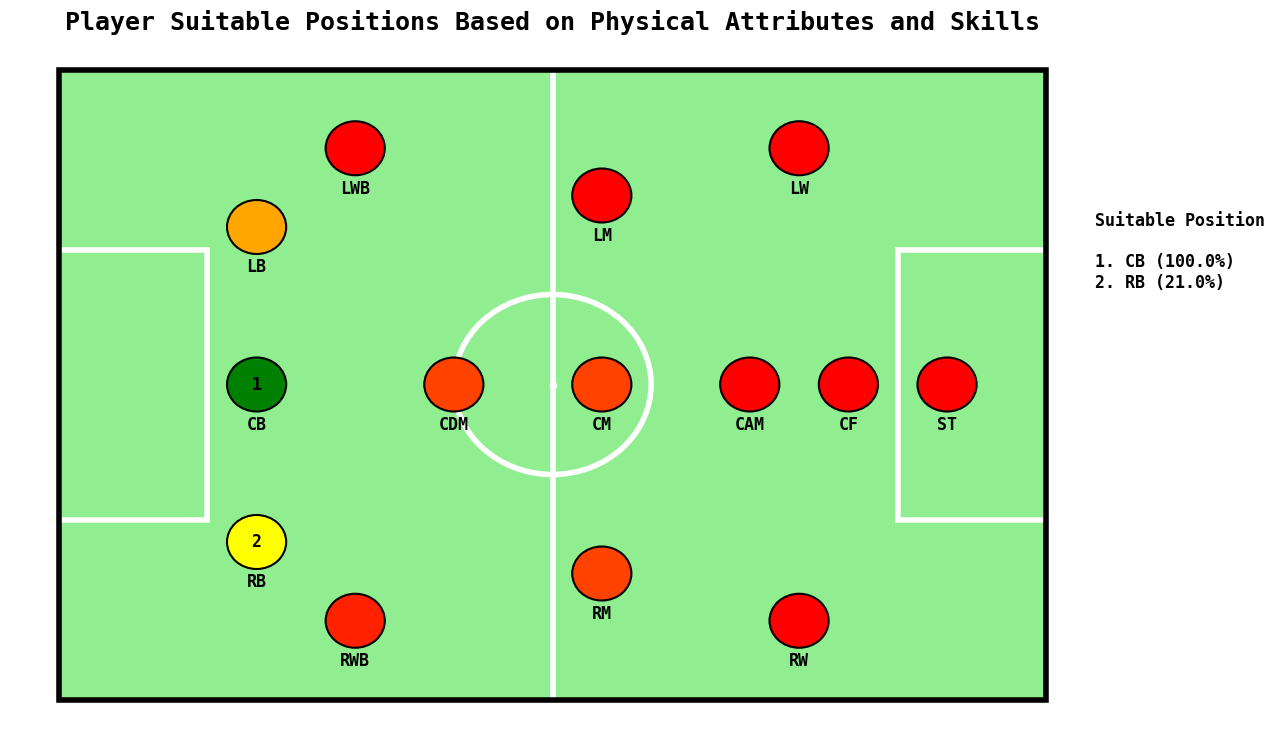

In [48]:
def search_index_fc25(df, name):
    count = 0
    for idx, short_name in df['Name'].items():
        if name.lower() in short_name.lower():
            print(f"Index: {idx}, Name: {short_name}")
            count += 1
        if count == 10 : return
    if count == 0 : print('Not Found')

name_search = input("Input Name (to continue enter 'e'):")
while name_search != 'e':
    search_index_fc25(fc25_df, name_search)
    name_search = input("Input Name (to continue enter 'e'):")

player_idx = int(input("Input Index in Dataset:"))
player_name = fc25_df.loc[player_idx, 'Name']
actual_positions = fc25_df.loc[player_idx, 'Positions']

player = get_player_input_from_df(fc25_df, player_idx)
sorted_selections = select_and_sort(clf_forest, player, feature_columns, pos_list)

print(f"Player Name: {player_name}")
print(f"Actual positions: {', '.join(actual_positions)}")

visualize_results(sorted_selections)

## `STEP 6: Building a Web Interface with Streamlit`

**`6.1 Building a Web App with Streamlit (app.py)`**

In [ ]:
%%writefile app.py

# ------------------------- Import important tools ---------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib # For saving and load8ing the model
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import streamlit as st

clf_forest = joblib.load('/content/drive/My Drive/random_forest_model.pkl') # Accuracy = 92.5% From 200 test data

# --------------------------- Define all lists ---------------------------------------
feature_columns = ['height_m', 'weight_kg', 'bmi', 'preferred_foot', 'weak_foot', 'skill_moves',
        'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing',
        'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
        'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina',
        'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
        'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
        'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
        'offensive_avg', 'defensive_avg', 'physical_avg', 'playmaking_avg', 'pace_agility_avg',
        'shooting_avg','offensive_defensive_ratio', 'attacking_contribution', 'defensive_contribution']

pos_list = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
            'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
            'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']

# ------------------------------- Define all functions ------------------------------------------
def select_player_positions(clf, player_features, feature_columns):
    player_df = pd.DataFrame([player_features], columns=feature_columns)

    # Get probability for each position
    position_probabilities = []
    for estimator in clf.estimators_:
        probas = estimator.predict_proba(player_df)[0]
        # Check if the classifier was trained on this class
        if len(probas) > 1:
            position_probabilities.append(probas[1])
        else:
            position_probabilities.append(0.0)

    return position_probabilities

def select_and_sort(clf, player_features, feature_columns, pos_list):
    probabilities = select_player_positions(clf, player_features, feature_columns)
    pos_prob_pairs = list(zip(pos_list, probabilities))
    sorted_pairs = sorted(pos_prob_pairs, key=lambda x: x[1], reverse=True)

    return sorted_pairs

def visualize_results(sorted_selections):

    def preprocess(sorted_selections):
        not_found_pos = ['LS', 'RS', 'LF', 'RF', 'LAM', 'RAM', 'LCM', 'RCM', 'LDM', 'RDM', 'LCB', 'RCB']
        filtered_selections = [item for item in sorted_selections if item[0] not in not_found_pos]
        probabilities = dict(filtered_selections)
        return probabilities

    probabilities = preprocess(sorted_selections)

    # Define positions and their coordinates on a football pitch
    positions = {
        'ST': (0.9, 0.5),
        'LW': (0.75, 0.875),
        'RW': (0.75, 0.125),
        'CF': (0.8, 0.5),
        'CAM': (0.7, 0.5),
        'CM': (0.55, 0.5),
        'RM': (0.55, 0.2),
        'LM': (0.55, 0.8),
        'LWB': (0.3, 0.875),
        'RWB': (0.3, 0.125),
        'CDM': (0.4, 0.5),
        'RB': (0.2, 0.25),
        'CB': (0.2, 0.5),
        'LB': (0.2, 0.75)
    }

    # Group positions based on the probability threshold of 0.15
    top_positions = {pos for pos, prob in probabilities.items() if prob >= 0.15}

    # Separate groups for color mapping
    top_probs = [probabilities[pos] for pos in top_positions]
    others_probs = [prob for pos, prob in probabilities.items() if pos not in top_positions]

    # Calculate min and max for each group
    top_min = min(top_probs) if top_probs else 0.15
    top_max = max(top_probs) if top_probs else 1.0
    others_min = min(others_probs) if others_probs else 0.0
    others_max = max(others_probs) if others_probs else 0.14

    # Define a function for interpolating custom colors
    import numpy as np
    import matplotlib.colors as mcolors

    def interpolate_color(color_range, value):
        return tuple((1 - value) * np.array(mcolors.to_rgb(color_range[0])) + value * np.array(mcolors.to_rgb(color_range[1])))

    # Plot the football pitch
    fig, ax = plt.subplots(figsize=(14, 9))

    # Draw the pitch (adjusted for rectangle size)
    pitch = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="lightgreen", lw=2)
    ax.add_patch(pitch)

    # Add halfway line
    plt.plot([0.5, 0.5], [0, 0.7], color="white", linewidth=4)

    # Add penalty areas
    penalty_box_left = patches.Rectangle([0, 0.2], 0.15, 0.3, edgecolor="white", facecolor="none", lw=4)
    penalty_box_right = patches.Rectangle([0.85, 0.2], 0.15, 0.3, edgecolor="white", facecolor="none", lw=4)
    ax.add_patch(penalty_box_left)
    ax.add_patch(penalty_box_right)

    # Add center circle
    center_circle = patches.Circle([0.5, 0.35], 0.1, edgecolor="white", facecolor="none", lw=4)
    ax.add_patch(center_circle)
    plt.scatter(0.5, 0.35, color="white", s=20)  # Center dot

    # Create a ranking for top positions based on their probability
    sorted_top_positions = sorted(top_positions, key=lambda pos: probabilities[pos], reverse=True)
    top_position_ranks = {pos: rank + 1 for rank, pos in enumerate(sorted_top_positions)}

    # Plot player positions with enhanced markers
    for pos, coords in positions.items():
        x, y = coords
        prob = probabilities.get(pos, 0.0)

        # Determine color based on group
        if prob == 0:
            color = "red"
        elif prob >= 0.6:
            color_range = ["greenyellow", "green"]
            norm_prob = (prob - 0.6) / (1.0 - 0.6)
            color = interpolate_color(color_range, norm_prob)
        elif pos in top_positions:
            color_range = ["yellow", "greenyellow"]
            norm_prob = (prob - top_min) / (top_max - top_min) if top_max > top_min else 1
            color = interpolate_color(color_range, norm_prob)
        else:
            color_range = ["red", "orange"]
            norm_prob = (prob - others_min) / (others_max - others_min) if others_max > others_min else 0
            color = interpolate_color(color_range, norm_prob)

        circle = plt.Circle((x, y * 0.7), 0.03, color=color, ec="black", lw=1.5)  # Adjust y for pitch height
        ax.add_artist(circle)
        plt.text(x, y * 0.7 - 0.05, pos, ha='center', fontsize=12, weight="bold", fontfamily="monospace", color="black")

        # Add rank (based on top positions)
        if pos in top_positions:
            rank = top_position_ranks[pos]
            plt.text(x, y * 0.7, f'{rank}', ha='center', va='center', fontsize=12, weight="bold", fontfamily="monospace", color="black")

    # Add border around the pitch after adding other elements
    border = patches.Rectangle([0, 0], 1, 0.7, edgecolor="black", facecolor="none", lw=4, zorder=3)
    ax.add_patch(border)

    # Add title
    plt.title("Player Suitable Positions Based on Physical Attributes and Skills", fontsize=18, fontweight="bold", fontfamily="monospace", color="black")

    # Add the rank list to the right side with a title
    rank_text = "Suitable Position\n\n" + '\n'.join([f"{rank}. {pos} ({probabilities[pos]*100:.1f}%)" for rank, pos in enumerate(sorted_top_positions, start=1)])
    plt.text(1.00, 0.75, rank_text, ha='left', va='top', fontsize=12, weight="bold", fontfamily="monospace", color="black", transform=ax.transAxes)

    plt.axis('off')
    plt.show()

    return fig

# ------------------------------ Create website by Streamlit -------------------------------------------
def get_player_input_streamlit():
    st.title("Player Input Form")
    st.write("Enter the player's physical details, skill levels, and other attributes below:")

    # Physical details
    st.header("Physical Details")
    height_cm = st.number_input("Height (cm):", min_value=100.0, max_value=250.0, step=0.1)
    weight_kg = st.number_input("Weight (kg):", min_value=30.0, max_value=150.0, step=0.1)
    height_m = height_cm / 100
    bmi = weight_kg / (height_m ** 2) if height_m > 0 else 0

    # Foot preferences
    st.header("Foot and Skill Details")
    preferred_foot = st.selectbox("Preferred foot:", ["Right", "Left"])
    weak_foot = st.slider("Weak foot (1-5):", 1, 5)
    skill_moves = st.slider("Skill moves (1-5):", 1, 5)

    # Skills
    st.header("Skills")
    st.subheader("Pace")
    movement_acceleration = st.slider("Acceleration (1-99):", 1, 99)
    movement_sprint_speed = st.slider("Sprint Speed (1-99):", 1, 99)

    st.subheader("Shooting")
    mentality_positioning = st.slider("Positioning (1-99):", 1, 99)
    attacking_finishing = st.slider("Finishing (1-99):", 1, 99)
    power_shot_power = st.slider("Shot Power (1-99):", 1, 99)
    power_long_shots = st.slider("Long Shots (1-99):", 1, 99)
    attacking_volleys = st.slider("Volleys (1-99):", 1, 99)
    mentality_penalties = st.slider("Penalties (1-99):", 1, 99)

    st.subheader("Passing")
    mentality_vision = st.slider("Vision (1-99):", 1, 99)
    attacking_crossing = st.slider("Crossing (1-99):", 1, 99)
    skill_fk_accuracy = st.slider("Free Kick Accuracy (1-99):", 1, 99)
    attacking_short_passing = st.slider("Short Passing (1-99):", 1, 99)
    skill_long_passing = st.slider("Long Passing (1-99):", 1, 99)
    skill_curve = st.slider("Curve (1-99):", 1, 99)

    st.subheader("Dribbling")
    movement_agility = st.slider("Agility (1-99):", 1, 99)
    movement_balance = st.slider("Balance (1-99):", 1, 99)
    movement_reactions = st.slider("Reactions (1-99):", 1, 99)
    skill_ball_control = st.slider("Ball Control (1-99):", 1, 99)
    skill_dribbling = st.slider("Dribbling (1-99):", 1, 99)
    mentality_composure = st.slider("Composure (1-99):", 1, 99)

    st.subheader("Defending")
    mentality_interceptions = st.slider("Interceptions (1-99):", 1, 99)
    attacking_heading_accuracy = st.slider("Heading Accuracy (1-99):", 1, 99)
    defending_marking_awareness = st.slider("Defending Awareness (1-99):", 1, 99)
    defending_standing_tackle = st.slider("Standing Tackle (1-99):", 1, 99)
    defending_sliding_tackle = st.slider("Sliding Tackle (1-99):", 1, 99)

    st.subheader("Physicality")
    power_jumping = st.slider("Jumping (1-99):", 1, 99)
    power_stamina = st.slider("Stamina (1-99):", 1, 99)
    power_strength = st.slider("Strength (1-99):", 1, 99)
    mentality_aggression = st.slider("Aggression (1-99):", 1, 99)

    if st.button("Process and Visualize"):
        # Gather inputs into a list
        raw_inputs = [
            height_m, weight_kg, bmi, 0 if preferred_foot == "Right" else 1, weak_foot, skill_moves,
            movement_acceleration, movement_sprint_speed, mentality_positioning, attacking_finishing,
            power_shot_power, power_long_shots, attacking_volleys, mentality_penalties, mentality_vision,
            attacking_crossing, skill_fk_accuracy, attacking_short_passing, skill_long_passing, skill_curve,
            movement_agility, movement_balance, movement_reactions, skill_ball_control, skill_dribbling,
            mentality_composure, mentality_interceptions, attacking_heading_accuracy, defending_marking_awareness,
            defending_standing_tackle, defending_sliding_tackle, power_jumping, power_stamina, power_strength,
            mentality_aggression
        ]

        # Normalize skills (same as in get_player_input)
        skills = [
            attacking_crossing, attacking_finishing, attacking_heading_accuracy, attacking_short_passing,
            attacking_volleys, skill_dribbling, skill_curve, skill_fk_accuracy, skill_long_passing,
            skill_ball_control, movement_acceleration, movement_sprint_speed, movement_agility,
            movement_reactions, movement_balance, power_shot_power, power_jumping, power_stamina,
            power_strength, power_long_shots, mentality_aggression, mentality_interceptions,
            mentality_positioning, mentality_vision, mentality_penalties, mentality_composure,
            defending_marking_awareness, defending_standing_tackle, defending_sliding_tackle
        ]

        # Find the best skill for normalization
        best_skills = max(skills)

        # Normalize all skills by dividing by the best skill
        normalized_skills = [skill / best_skills for skill in skills]

        # Calculate averages
        offensive_avg = (attacking_crossing + attacking_finishing + attacking_volleys +
                         mentality_positioning + skill_dribbling + skill_curve) / (6 * best_skills)
        defensive_avg = (mentality_aggression + mentality_interceptions + defending_marking_awareness +
                         defending_standing_tackle + defending_sliding_tackle) / (5 * best_skills)
        physical_avg = (power_strength + power_stamina + power_jumping + movement_balance) / (4 * best_skills)
        playmaking_avg = (mentality_vision + attacking_short_passing + skill_long_passing +
                          skill_fk_accuracy + skill_curve) / (5 * best_skills)
        pace_agility_avg = (movement_acceleration + movement_sprint_speed + movement_agility +
                            movement_reactions) / (4 * best_skills)
        shooting_avg = (attacking_finishing + attacking_volleys + power_shot_power +
                        power_long_shots + mentality_penalties) / (5 * best_skills)

        normalized_averages = [offensive_avg, defensive_avg, physical_avg, playmaking_avg, pace_agility_avg, shooting_avg]

        # Additional features
        offensive_defensive_ratio = offensive_avg / (defensive_avg + 1e-5)
        attacking_contribution = (offensive_avg + shooting_avg + playmaking_avg) / 3
        defensive_contribution = (defensive_avg + physical_avg) / 2

        # Normalize the additional features
        normalized_additional_features = [offensive_defensive_ratio, attacking_contribution, defensive_contribution]

        # Return the list of features
        player_features = [height_m, weight_kg, bmi, 0 if preferred_foot == "Right" else 1, weak_foot, skill_moves] + normalized_skills + normalized_averages + normalized_additional_features

        # Assuming clf_forest, pos_list, and feature_columns are defined elsewhere
        sorted_selections = select_and_sort(clf_forest, player_features, feature_columns, pos_list)

        # Call the visualization function
        fig = visualize_results(sorted_selections)
        st.pyplot(fig)


get_player_input_streamlit()

**`6.2 Running the App on Colab (Local Run is Faster)`**

In [ ]:
! wget -q -O - ipv4.icanhazip.com

In [ ]:
! streamlit run app.py & npx localtunnel --port 8501